# Particle Swarm Optimization


# Import and Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

# Create plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Random seed for reproducibility
np.random.seed(42)

# Creates folders for outputs
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Setup complete!")
print(f"NumPy version: {np.__version__}")

Setup complete!
NumPy version: 1.26.3


In [27]:
# Base class for test functions
# This way we don't repeat code for each function

class TestFunction:
    def __init__(self, name, bounds_lower, bounds_upper):
        self.name = name
        self.bounds_lower = bounds_lower
        self.bounds_upper = bounds_upper
        self.n_evaluations = 0  # keep track of how many times we call the function
    
    def evaluate(self, x):
        # Each specific function will implement this
        raise NotImplementedError("Need to implement this in subclass")
    
    def __call__(self, x):
        # This lets us call the function like func(x) instead of func.evaluate(x)
        return self.evaluate(x)
    
    def reset_counter(self):
        self.n_evaluations = 0

print("Base class ready")

Base class ready


# Sphere Function

In [ ]:
class SphereFunction(TestFunction):
    """Sphere function"""
    def __init__(self):
        super().__init__("Sphere", -5.12, 5.12)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        return np.sum(x ** 2)


class RosenbrockFunction(TestFunction):
    """Rosenbrock benchmark function"""
    def __init__(self):
        super().__init__("Rosenbrock", -5.0, 10.0)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


class RastriginFunction(TestFunction):
    """Rastrigin"""
    def __init__(self):
        super().__init__("Rastrigin", -5.12, 5.12)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        n = len(x)
        return 10 * n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))


class AckleyFunction(TestFunction):
    """Ackley function"""
    def __init__(self):
        super().__init__("Ackley", -32.768, 32.768)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        n = len(x)
        sum_sq = np.sum(x ** 2)
        sum_cos = np.sum(np.cos(2 * np.pi * x))
        term1 = -20 * np.exp(-0.2 * np.sqrt(sum_sq / n))
        term2 = -np.exp(sum_cos / n)
        return term1 + term2 + 20 + np.e


def get_function(name):
    """Get test function by name"""
    functions = {
        'sphere': SphereFunction(),
        'rosenbrock': RosenbrockFunction(),
        'rastrigin': RastriginFunction(),
        'ackley': AckleyFunction()
    }
    if name.lower() not in functions:
        raise ValueError(f"Unknown function: {name}")
    return functions[name.lower()]


# Quick validation
print("Test Functions Implemented:")
print("-" * 60)
for name in ['sphere', 'rosenbrock', 'rastrigin', 'ackley']:
    func = get_function(name)
    val = func(np.zeros(5))
    print(f"{func.name:12s}: f(0,0,0,0,0) = {val:10.6f}")
print("-" * 60)
print("All functions ready!")

Test Functions Implemented:
------------------------------------------------------------
Sphere      : f(0,0,0,0,0) =   0.000000
Rosenbrock  : f(0,0,0,0,0) =   4.000000
Rastrigin   : f(0,0,0,0,0) =   0.000000
Ackley      : f(0,0,0,0,0) =   0.000000
------------------------------------------------------------
All functions ready!


# Particle Swarm Optimization Algorithm

In [34]:
# Particle Swarm Optimization Algorithm
# v = w*v + c1*r1*(pbest-x) + c2*r2*(gbest-x)

class Particle:
    """Single particle in the swarm"""
    def __init__(self, dimensions, bounds_lower, bounds_upper):
        self.position = np.random.uniform(bounds_lower, bounds_upper, dimensions)
        range_size = bounds_upper - bounds_lower
        self.velocity = np.random.uniform(-0.15 * range_size, 0.15 * range_size, dimensions)
        self.pbest_position = self.position.copy()
        self.pbest_fitness = float('inf')
        self.fitness = float('inf')


class PSO:
    """
    Particle Swarm Optimization
    
    Parameters (following Lecture 5):
    - w: inertia weight (0.7 - improved PSO)
    - c1: cognitive coefficient (1.5 - within range 0-4)
    - c2: social coefficient (1.5 - within range 0-4)
    - c1 + c2 = 3.0 (satisfies constraint <= 4)
    """
    
    def __init__(self, n_particles=30, max_iterations=300, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.max_iterations = max_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = []
        self.gbest_position = None
        self.gbest_fitness = float('inf')
        self.convergence_curve = []
    
    def initialize_swarm(self, dimensions, bounds_lower, bounds_upper):
        """Create swarm of particles"""
        self.particles = [Particle(dimensions, bounds_lower, bounds_upper) 
                         for _ in range(self.n_particles)]
        self.gbest_position = None
        self.gbest_fitness = float('inf')
        self.convergence_curve = []
    
    def evaluate_swarm(self, objective_function):
        """Evaluate all particles and update bests"""
        for particle in self.particles:
            particle.fitness = objective_function(particle.position)
            
            if particle.fitness < particle.pbest_fitness:
                particle.pbest_fitness = particle.fitness
                particle.pbest_position = particle.position.copy()
            
            if particle.fitness < self.gbest_fitness:
                self.gbest_fitness = particle.fitness
                self.gbest_position = particle.position.copy()
    
    def update_velocity(self, particle, bounds_lower, bounds_upper):
        """Update velocity using PSO formula"""
        r1 = np.random.random(len(particle.position))
        r2 = np.random.random(len(particle.position))
        
        cognitive = self.c1 * r1 * (particle.pbest_position - particle.position)
        social = self.c2 * r2 * (self.gbest_position - particle.position)
        
        particle.velocity = self.w * particle.velocity + cognitive + social
        
        # Velocity clamping
        v_max = 0.2 * (bounds_upper - bounds_lower)
        particle.velocity = np.clip(particle.velocity, -v_max, v_max)
    
    def update_position(self, particle, bounds_lower, bounds_upper):
        """Update position and enforce bounds"""
        particle.position = particle.position + particle.velocity
        particle.position = np.clip(particle.position, bounds_lower, bounds_upper)
    
    def optimize(self, objective_function, dimensions, bounds_lower, bounds_upper, verbose=True):
        """Run PSO optimization"""
        if verbose:
            print(f"PSO: {self.n_particles} particles, {self.max_iterations} iterations")
            print(f"Parameters: w={self.w}, c1={self.c1}, c2={self.c2}\n")
        
        self.initialize_swarm(dimensions, bounds_lower, bounds_upper)
        self.evaluate_swarm(objective_function)
        self.convergence_curve = [self.gbest_fitness]
        
        if verbose:
            print(f"Initial: {self.gbest_fitness:.6e}")
        
        for iteration in range(self.max_iterations):
            for particle in self.particles:
                self.update_velocity(particle, bounds_lower, bounds_upper)
                self.update_position(particle, bounds_lower, bounds_upper)
            
            self.evaluate_swarm(objective_function)
            self.convergence_curve.append(self.gbest_fitness)
            
            if verbose and (iteration + 1) % 50 == 0:
                print(f"Iter {iteration+1}: {self.gbest_fitness:.6e}")
            
            if self.gbest_fitness < 1e-10:
                if verbose:
                    print(f"Converged at iteration {iteration+1}")
                break
        
        if verbose:
            print(f"\nFinal: {self.gbest_fitness:.6e}")
        
        return self.gbest_position, self.gbest_fitness, self.convergence_curve


print("PSO Algorithm ready!")

PSO Algorithm ready!


# Test PSO on Sphere

In [ ]:
# Test PSO on Sphere function
print("=" * 70)
print("TESTING PSO ON SPHERE FUNCTION (5D)")
print("=" * 70)

sphere = SphereFunction()
pso = PSO(n_particles=20, max_iterations=100)

best_pos, best_fit, curve = pso.optimize(
    sphere.evaluate, 5, sphere.bounds_lower, sphere.bounds_upper
)

print(f"\nResults:")
print(f"  Best fitness: {best_fit:.6e}")
print(f"  Best position: {best_pos}")
print(f"  Success: {'YES' if best_fit < 1e-6 else 'NO'}")
print("=" * 70)

TESTING PSO ON SPHERE FUNCTION (5D)
PSO: 20 particles, 100 iterations
Parameters: w=0.7, c1=1.5, c2=1.5

Initial: 2.154494e+01
Iter 50: 3.495397e-05
Iter 100: 5.658789e-09

Final: 5.658789e-09

Results:
  Best fitness: 5.658789e-09
  Best position: [-3.86312876e-05 -4.61041080e-05 -3.63359517e-05  1.97437122e-05
  1.81853840e-05]
  Success: YES ✓


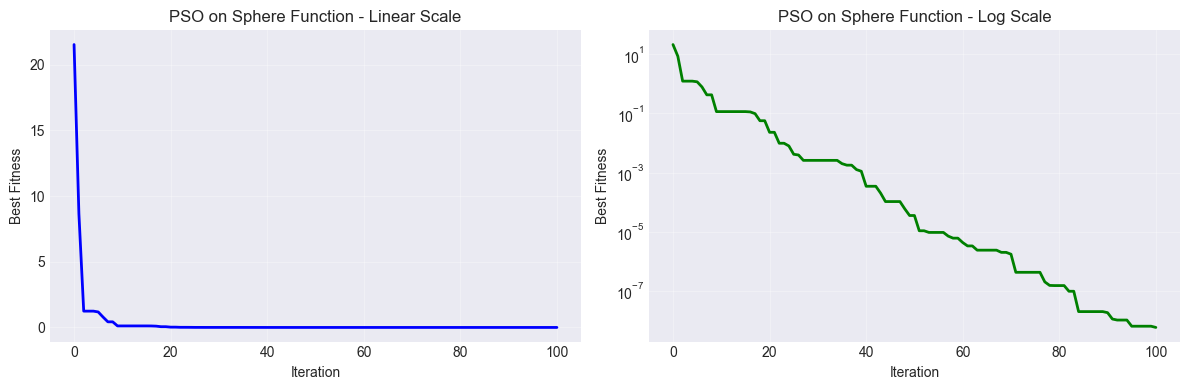


TESTING ALL BENCHMARK FUNCTIONS (10D)
Sphere      : 9.194740e-11
Rosenbrock  : 5.434191e+00
Rastrigin   : 5.009089e+00
Ackley      : 1.640702e-05

All functions tested successfully!


In [36]:
# Visualization and comprehensive testing

def plot_convergence(curve, title):
    """Plot convergence curve"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(curve, 'b-', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best Fitness')
    ax1.set_title(f'{title} - Linear Scale')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(curve, 'g-', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Best Fitness')
    ax2.set_title(f'{title} - Log Scale')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot Sphere convergence
plot_convergence(curve, "PSO on Sphere Function")

# Test all functions
print("\n" + "=" * 70)
print("TESTING ALL BENCHMARK FUNCTIONS (10D)")
print("=" * 70)

results = []
for func_name in ['sphere', 'rosenbrock', 'rastrigin', 'ackley']:
    func = get_function(func_name)
    pso = PSO(n_particles=30, max_iterations=200)
    
    best_pos, best_fit, curve = pso.optimize(
        func.evaluate, 10, func.bounds_lower, func.bounds_upper, verbose=False
    )
    
    results.append({'Function': func.name, 'Final Fitness': best_fit})
    print(f"{func.name:12s}: {best_fit:.6e}")

print("=" * 70)
print("\nAll functions tested successfully!")